# Testing out Turing.jl and my model without ModelingToolkit
Following [demo code](https://turing.ml/dev/tutorials/10-bayesian-differential-equations/) examples.

This notebook follows on from ```38_MMS_demo_mtoolkit.ipynb```

In [54]:
using Turing
using DifferentialEquations

# Load StatsPlots for visualizations and diagnostics.
using StatsPlots

using LinearAlgebra, DataStructures

# Used for discarding warnings
using Logging: with_logger, NullLogger

# Set a seed for reproducibility.
using Random
Random.seed!(20);

## Mavelli ODE model setup
This creates and ODESystem usine DifferentialEquations.jl.

In [55]:
function mavelli(du, u, p, t)

    function MM(c, K)
        return(c/(K+c))
    end

    # Constant multiplicities
    n_NTP = 4
    n_A = 20
    n_T = 46

    # Static state
    DNA = 1.7e-3  # d in NL code
    C_TXcat = 0.1
    C_RScat = 0.16
    C_ENcat = 0.08

    # Parameters of the model - 16 values
    k_TX, k_TL, k_RS, k_EN, k_nt_deg, k_TL_deg, K_TX_DNA,
    K_TX_NTP, K_TL_nt, K_TL_AT, K_TL_NTP, K_RS_A, K_RS_T,
    K_RS_NTP, K_EN_CP, K_EN_NXP = p

    # Dynamic state up DNA so 11 variables and 4 static state
    NTP, NXP, nt, PPi, AT, a, T, A, CP, C, C_TLcat = u

    c_avg_tRNA_aa = n_T / n_A

    # MMS Eq 5
    V_TX = (k_TX * C_TXcat
            * MM(DNA, K_TX_DNA)
            * MM(NTP, K_TX_NTP))

    # MMS Eq 10
    V_TL = (k_TL * C_TLcat * MM(nt, K_TL_nt)
            * MM(c_avg_tRNA_aa * AT, K_TL_AT)
            * MM(NTP, K_TL_NTP))

    # MMS Eq 8
    V_RS = (k_RS * C_RScat
            * MM(A, K_RS_A)
            * MM(c_avg_tRNA_aa * T, K_RS_T)
            * MM(NTP, K_RS_NTP))

    # MMS Eq 14
    V_EN = (k_EN * C_ENcat
            * MM(CP, K_EN_CP)
            * MM(NXP, K_EN_NXP))

    # MMS Eq 20
    dot_NTP = -V_TX - 2 * V_TL - V_RS + V_EN

    # MMS EQ 21
    dot_NXP = 2 * V_TL + V_RS - V_EN

    # MMS EQ 22
    dot_nt = V_TX - k_nt_deg * nt

    # From NL code
    dot_Ppi = V_TX

    # MMS EQ 24
    dot_AT = V_RS - V_TL

    # MMS EQ 25
    dot_a = V_TL

    # MMS EQ 24
    dot_T = -V_RS + V_TL

    # MMS EQ 23
    dot_A = -V_RS

    # MMS EQ 26
    dot_CP = -V_EN
    dot_C = V_EN

    # MMS EQ 27
    dot_C_TLcat = -C_TLcat * k_TL_deg

    du[1]  = dot_NTP
    du[2]  = dot_NXP
    du[3]  = dot_nt
    du[4]  = dot_Ppi
    du[5]  = dot_AT
    du[6]  = dot_a
    du[7]  = dot_T
    du[8]  = dot_A
    du[9]  = dot_CP
    du[10] = dot_C
    du[11] = dot_C_TLcat

    #@SVector [dot_NTP, dot_NXP, dot_nt, dot_Ppi, dot_AT, dot_a, dot_T, dot_A, dot_CP, dot_C, dot_C_TLcat]

end

mavelli (generic function with 1 method)

## Demo of Mavelli ODE
This section demonstrates how to use the ODE to generate time series.

### Initial variables

In [56]:
vars_default_dict = DataStructures.OrderedDict(
    "NTP" => 1500.0,
    "NXP" => 0.0,
    "nt" => 0.0,
    "Ppi" => 0.0,
    "AT" => 0.0,
    "a" => 0.0,
    "T" => 1.9,
    "A" => 300.0,
    "CP" => 20000.0,
    "C" => 0.0,
    "C_TLcat" => 2.2)
var_default_arr=collect(values(vars_default_dict))

11-element Vector{Float64}:
  1500.0
     0.0
     0.0
     0.0
     0.0
     0.0
     1.9
   300.0
 20000.0
     0.0
     2.2

### Initial parameters

In [57]:
param_default_dict = DataStructures.OrderedDict(
    "k_TX" => 1.67,
    "k_TL" => 0.085,
    "k_RS" => 6.2,
    "k_EN" => 100,
    "k_nt_deg" => 7.92e-5,
    "k_TL_deg" => 1.86e-4,
    "K_TX_DNA" => 5e-3,
    "K_TX_NTP" => 80,
    "K_TL_nt" => 226,
    "K_TL_AT" => 10,
    "K_TL_NTP" => 10,
    "K_RS_A" => 23,
    "K_RS_T" => 0.7,
    "K_RS_NTP" => 200,
    "K_EN_CP" => 200,
    "K_EN_NXP" => 40)
param_default_arr=collect(values(param_default_dict))

16-element Vector{Real}:
   1.67
   0.085
   6.2
 100
   7.92e-5
   0.000186
   0.005
  80
 226
  10
  10
  23
   0.7
 200
 200
  40

In [58]:
# Define initial-value problem.
tspan = (1.0, 6 * 60.0 * 60.0)
prob = ODEProblem(mavelli, var_default_arr, tspan, param_default_arr)
sol = solve(prob, Tsit5(); save_end=false, saveat=120.0); 

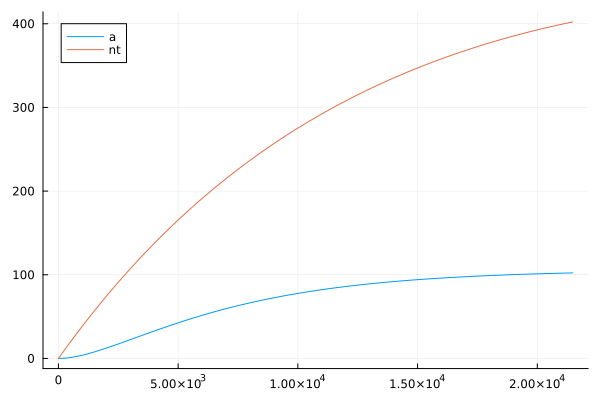

In [59]:
# Plot simulation.
plot(sol.t, transpose(sol[[6, 3],:]); labels=["a" "nt"])

## Making synthetic observations
As with the Turing.jl examples we can add noise to the ODE solutions to simulate a simple observation model.

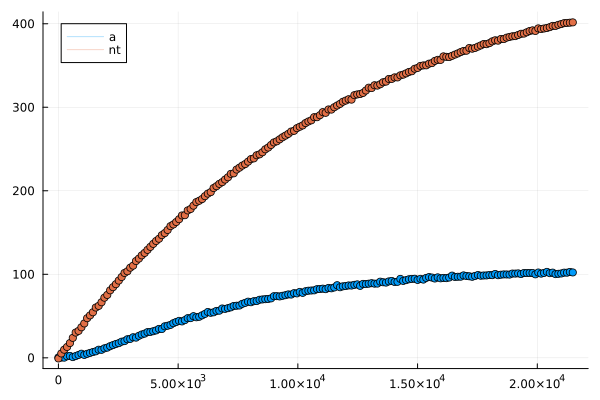

In [60]:
vars_to_use = [6, 3]
sol_all = solve(prob, Tsit5(); save_end=false, saveat=120.0)
sol_to_use = sol_all[vars_to_use, :]
odedata = Array(sol_to_use) .+ 0.8 .* randn(size(Array(sol_to_use)))

# Plot simulation and noisy observations.
plot(sol_all.t, transpose(sol_to_use); alpha=0.3, labels=["a" "nt"])
scatter!(sol_all.t, transpose(odedata); color=[1 2], label="")

## Fitting a model

In [61]:
@model function fitmavelli(data, ode_prob, vars_to_use)

    # Noise for simulated observations
    #sigma ~ InverseGamma(2, 3)
    sigma_sq = 0.01
    epsilon = 0.000001

    # Prior distributions
    dk_TX ~ Uniform(1, 4)
    dk_TL ~ Uniform(0.03, 1.5)
    dk_RS ~ Uniform(6, 6.2)
    dk_EN ~ Uniform(90, 110)
    dK_RS_NTP ~ Uniform(190, 210)
    dK_EN_CP ~ Uniform(190, 210)
    dK_EN_NXP ~ Uniform(30, 50)
    dK_TL_nt ~ Uniform(220, 230)
    dK_TL_NTP ~ Uniform(5, 15)
    dK_RS_A ~ Uniform(18, 30)
    dK_RS_T ~ Uniform(0.2, 1.4)
    dK_TX_NTP ~ Uniform(70, 90)
    dk_nt_deg ~ Uniform(1e-05, 0.0001)
    dK_TX_DNA ~ Uniform(0.001, 10)
    dk_TL_deg ~ Uniform(1e-05, 0.001)
    dK_TL_AT ~ Uniform(5, 15)

    params = [dk_TX, dk_TL, dk_RS, dk_EN, dk_nt_deg, dk_TL_deg,
              dK_TX_DNA, dK_TX_NTP, dK_TL_nt, dK_TL_AT,
              dK_TL_NTP, dK_RS_A, dK_RS_T, dK_RS_NTP,
              dK_EN_CP, dK_EN_NXP]

    predicted_sol = solve(ode_prob; p=params, save_end=false, saveat=120.0)
    predicted = predicted_sol[vars_to_use, :]
    
    # Observations.
    for i in 1:size(predicted,1)
        data[i, :] ~ MvNormal(predicted[i, :], sigma_sq * I)
    end

    return nothing
end

fitmavelli (generic function with 2 methods)

In [62]:
function make_data(ode_prob, vars_to_use::Vector{Int})
    soln_all_vars = solve(ode_prob, save_end=false, saveat=120.0)
    odedata = soln_all_vars[vars_to_use, :]
    odedatarand = odedata .+ (0.8 .* randn(size(odedata)))
    return odedata
end

make_data (generic function with 1 method)

### Make some data and create a model

In [63]:
tspan = (1.0, 6 * 60 * 60)
ode_prob = ODEProblem(mavelli, var_default_arr, tspan, param_default_arr)
ode_data = make_data(ode_prob, vars_to_use)
model = fitmavelli(ode_data, ode_prob, vars_to_use);

### Draw samples using HMC

In [74]:
sampler = NUTS(0.65)
n_samples, n_chains = 1000, 5
chain = with_logger(NullLogger()) do
    sample(model, sampler, MCMCSerial(), n_samples, n_chains; progress=false)
end

Chains MCMC chain (1000×28×5 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 5
Samples per chain = 1000
Wall duration     = 79.5 seconds
Compute duration  = 79.44 seconds
parameters        = dk_TX, dk_TL, dk_RS, dk_EN, dK_RS_NTP, dK_EN_CP, dK_EN_NXP, dK_TL_nt, dK_TL_NTP, dK_RS_A, dK_RS_T, dK_TX_NTP, dk_nt_deg, dK_TX_DNA, dk_TL_deg, dK_TL_AT
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std   naive_se      mcse       ess          rhat ⋯
      Symbol    Float64   Float64    Float64   Float64   Float64       Float64 ⋯

       dk_TX     2.8481    0.6236     0.0088    0.0732   10.0000      427.1713 ⋯
       dk_TL     0.8766    0.4789     0.0068    0.0567   10.0000     9111.9210 ⋯
       dk_RS     6.1267    0.0153     0.0002    0.0018   10.0000    19452.8365 ⋯
   

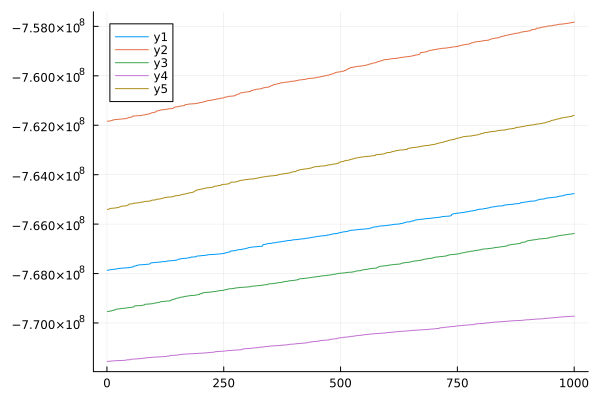

In [75]:
plot(chain[:lp])

In [76]:
plot(chains)

In [77]:
using Pkg: Pkg
Pkg.status()

      Status `/disk/scratch/s2125151/code/src/github.com/sandy6502/TuringExp.jl/Project.toml`
  [864edb3b] DataStructures v0.18.13
  [0c46a032] DifferentialEquations v7.7.0
  [7073ff75] IJulia v1.24.0
  [961ee093] ModelingToolkit v8.56.0
  [1ed8b502] SciMLSensitivity v7.31.0
  [f3b207a7] StatsPlots v0.15.5
  [fce5fe82] Turing v0.22.0
  [e88e6eb3] Zygote v0.6.61
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random


In [78]:
using InteractiveUtils
versioninfo()

Julia Version 1.6.7
Commit 3b76b25b64 (2022-07-19 15:11 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i9-9900 CPU @ 3.10GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)
Environment:
  JULIA_DEPOT_PATH = /disk/scratch/s2125151/opt/julia_depot
